# Amazon Reviews Sentiment Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sb
from sklearn import metrics
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import math
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sb.set_style("whitegrid")

Importing the data

In [2]:
csv_file = "./data/Reviews.csv"
df = pd.read_csv(csv_file)
print('Total review count:', len(df))
print("Number  of  Products  for  reviews :", len(df["ProductId"].unique()))
print("Number of Unique users for reviews :", len(df["UserId"].unique()))


Total review count: 568454
Number  of  Products  for  reviews : 74258
Number of Unique users for reviews : 256059


In [13]:
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


It means a single product do have multiple reviews 

In [14]:
filtered_df = df.query('ProductId == "B006K2ZZ7K"')
filtered_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Removing Uncessary Columns

In [15]:
data = df.copy()
data = data.drop(["Id","UserId","Time", "HelpfulnessNumerator", "HelpfulnessDenominator", "ProfileName"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  568454 non-null  object
 1   Score      568454 non-null  int64 
 2   Summary    568427 non-null  object
 3   Text       568454 non-null  object
dtypes: int64(1), object(3)
memory usage: 17.3+ MB


In [16]:
data.head()

,ProductId,Score,Summary,Text
0,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...


Getting count of unique products

In [17]:
unique_products_count = len(data["ProductId"].unique())
print(f"Number of Unique Product IDs: {unique_products_count}")

Number of Unique Product IDs: 74258


Plotting the histogram of scores to see their frequencies

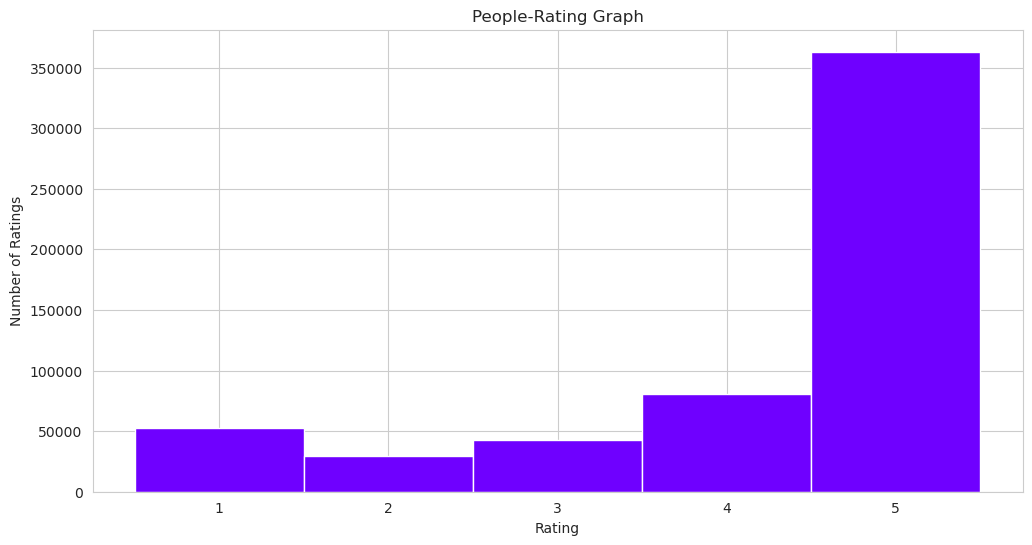

In [7]:
x_axis_rating = data["Score"]
x_axis_rating.hist(bins=[0.5,1.5,2.5,3.5,4.5,5.5], figsize=(12,6), grid=True, color="#6f00ff")

plt.title("People-Rating Graph")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.show()

We can clearly see that a lot of products have positive reviews.
The histogram might show a skew toward higher ratings, left skew 



Box-Plot gives the concentration data distribution

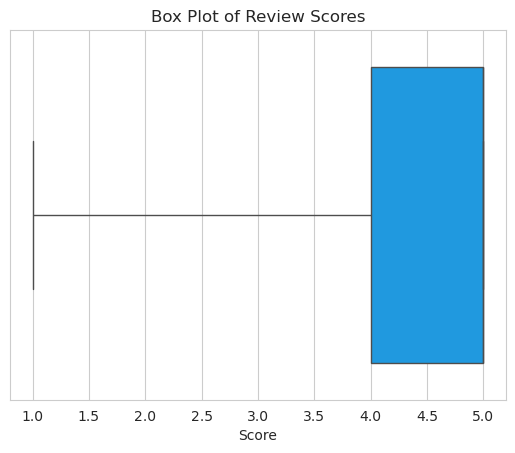

In [8]:
sb.boxplot(x="Score", data=data, whis=5, color="#00a2ff")
plt.title("Box Plot of Review Scores")
plt.xlabel("Score")
plt.show()

Violin-Plot gives the frequency distribution of the data to visualize how the data is distributed and which points have more concentration of the data

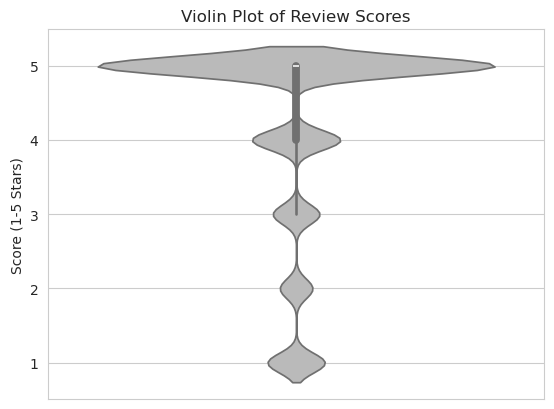

In [9]:
sb.violinplot(y="Score", data=data, bw=0.1, color="#bababa")
plt.title("Violin Plot of Review Scores")
plt.ylabel("Score (1-5 Stars)")
plt.show()

Dropping null values

In [20]:
dataAfter = data.dropna(subset=["Score"])
dataAfter["Score"] = dataAfter["Score"].astype(int)

In [21]:
dataAfter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductId  568454 non-null  object
 1   Score      568454 non-null  int64 
 2   Summary    568427 non-null  object
 3   Text       568454 non-null  object
dtypes: int64(1), object(3)
memory usage: 17.3+ MB


Splitting data into TRAIN & TEST datasets

In [25]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter, dataAfter["Score"]):  # ensuring each split preserves the distribution of scores (1–5).
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

In [23]:
len(strat_train), len(strat_test)

(454763, 113691)

In [24]:
strat_train.head()

,ProductId,Score,Summary,Text
61973,B000CQG8K8,5,Very Chai!,Wonderful smell and taste! I have regular and...
64634,B005NYXF00,5,Hometown Favorites High Five!,I just recieved my 90's candy box and could no...
257001,B003V8SO10,5,I'm from Brazil. This is the real stuff.,"I'm from Brazil, and when I'm home I usually d..."
479060,B001E5E074,5,Great,This a very good Cereal At a very good price I...
359033,B003CIBPN8,3,Tastes oddly like watery skim milk...,"I tried Zico in the plastic bottle, never in t..."


In [14]:
strat_train["Score"].value_counts()/len(strat_train)

Score
5    0.638790
4    0.141885
1    0.091947
3    0.075010
2    0.052368
Name: count, dtype: float64

In [15]:
strat_test["Score"].value_counts()/len(strat_test)

Score
5    0.638784
4    0.141885
1    0.091951
3    0.075010
2    0.052370
Name: count, dtype: float64

You can see that both training and test data have same score distrubution

Using Shuffled Train Dataset

In [27]:
reviews = strat_train.copy()
reviews.head()

,ProductId,Score,Summary,Text
248375,B0029NIYLS,5,Cesar,Genuine Cesar dog food at a great price. They...
355692,B002QWP8H0,5,Very Effective,My veterinarian recommended these. My dog is ...
565289,B001EO5U3I,5,The best oatmeal!,I just wanted to include a hint to this oatmea...
340753,B0027YUMRS,5,A healthy cookie my kid ASKED for???,"TOO GOOD TO BE TRUE!!! ""You know those cookies..."
245060,B000FFRTYK,4,Filling and tasty,It's so very hard to find real non-meat produc...


In [28]:
print(f"Number of unique Product IDs in Trained Data Reviews: ", len(reviews["ProductId"].unique()))

Number of unique Product IDs in Trained Data Reviews:  67669


In [32]:
reviews["Score"].mean(), dataAfter["Score"].mean()

(4.183203118987253, 4.183198640523243)

You can see a little difference deviation of the mean for the training sample and population

Counting Number of reviews of each Product from the Train dataset

In [33]:
counts = reviews["ProductId"].value_counts().to_frame()
counts.head(10)

,count
ProductId,
B007JFMH8M,730
B0026RQTGE,520
B002QWHJOU,515
B002QWP89S,508
B002QWP8H0,507
B003B3OOPA,502
B007M832YY,465
B007M83302,462
B0013NUGDE,462


Calculating the Mean rating score of each Product in the Train Dataset

In [34]:
avg_rating = reviews.groupby("ProductId")["Score"].mean().to_frame()
avg_rating.head(10)

,Score
ProductId,
0006641040,4.291667
2734888454,3.500000
7310172001,4.751773
7310172101,4.743056
7800648702,4.000000
B00002N8SM,1.866667
B00002NCJC,4.500000
B00002Z754,5.000000
B00004CI84,4.532468


Grouping the Product count and the Mean rating of each product in Train Dataset to form a Table

In [35]:
table = counts.join(avg_rating)
table.head(10)

,count,Score
ProductId,,
B007JFMH8M,730,4.558904
B0026RQTGE,520,4.594231
B002QWHJOU,515,4.582524
B002QWP89S,508,4.576772
B002QWP8H0,507,4.577909
B003B3OOPA,502,4.743028
B007M832YY,465,4.305376
B007M83302,462,4.307359
B0013NUGDE,462,4.316017


Scatter plots are used to observe relationships between variables. The dots in a scatter plot not only report the values of individual data points, but also patterns when the data are taken as a whole. Here, we can conclude that the number of times a product being purchased is affecting it's rating either in a good or a bad way.

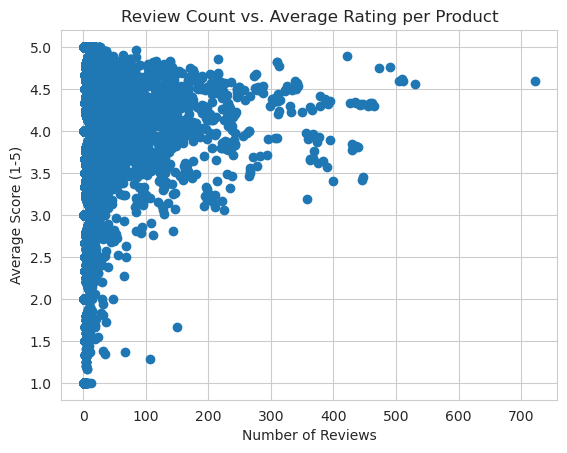

In [22]:
plt.scatter("count", "Score", data=table)
plt.title("Review Count vs. Average Rating per Product")
plt.xlabel("Number of Reviews")
plt.ylabel("Average Score (1-5)")
plt.show()

Classifying the review on the basis of rating

In [36]:
def label_sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

strat_train["Sentiment"] = strat_train["Score"].apply(label_sentiments)
strat_test["Sentiment"] = strat_test["Score"].apply(label_sentiments)

In [37]:
strat_train.head()

,ProductId,Score,Summary,Text,Sentiment
248375,B0029NIYLS,5,Cesar,Genuine Cesar dog food at a great price. They...,Positive
355692,B002QWP8H0,5,Very Effective,My veterinarian recommended these. My dog is ...,Positive
565289,B001EO5U3I,5,The best oatmeal!,I just wanted to include a hint to this oatmea...,Positive
340753,B0027YUMRS,5,A healthy cookie my kid ASKED for???,"TOO GOOD TO BE TRUE!!! ""You know those cookies...",Positive
245060,B000FFRTYK,4,Filling and tasty,It's so very hard to find real non-meat produc...,Positive


Calculating Precision, Recall and F-Score of the Algorithm using TP,TN,FP,FN

In [25]:
# Calculating other metrics

def calculate_precision(conf_mat):
    return (conf_mat[2][2]) / (conf_mat[2][2] + conf_mat[2][0])


def calculate_recall(conf_mat):
    return (conf_mat[2][2]) / (conf_mat[2][2] + conf_mat[0][2])


def calculate_f_score(algo_precision, algo_recall):
    return (2*(algo_precision * algo_recall)) / (algo_precision + algo_recall)

Pre-Processing Data

In [41]:
X_train = strat_train["Text"]
X_train_targetSentiment = strat_train["Sentiment"]
X_test = strat_test["Text"]
X_test_targetSentiment = strat_test["Sentiment"]
print(f"Number of Training Samples: {len(X_train)}")
print(f"Number of Test Data Samples: {len(X_test)}")
X_train

Number of Training Samples: 454763
Number of Test Data Samples: 113691


248375    Genuine Cesar dog food at a great price.  They...
355692    My veterinarian recommended these.  My dog is ...
565289    I just wanted to include a hint to this oatmea...
340753    TOO GOOD TO BE TRUE!!! "You know those cookies...
245060    It's so very hard to find real non-meat produc...
                                ...                        
442226    This water is awesome! Very light and refreshi...
290438    I love this tea! My wife is usually the big te...
155439    I am back to order another container of this s...
57424     As one other review states the bag was ripped ...
521813    I am so happy I found this product on Amazon! ...
Name: Text, Length: 454763, dtype: object

 Filling NA's with EMPTY STRING

In [43]:
X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
X_train_targetSentiment = X_train_targetSentiment.fillna(' ')
X_test_targetSentiment = X_test_targetSentiment.fillna(' ')

X_train

248375    Genuine Cesar dog food at a great price.  They...
355692    My veterinarian recommended these.  My dog is ...
565289    I just wanted to include a hint to this oatmea...
340753    TOO GOOD TO BE TRUE!!! "You know those cookies...
245060    It's so very hard to find real non-meat produc...
                                ...                        
442226    This water is awesome! Very light and refreshi...
290438    I love this tea! My wife is usually the big te...
155439    I am back to order another container of this s...
57424     As one other review states the bag was ripped ...
521813    I am so happy I found this product on Amazon! ...
Name: Text, Length: 454763, dtype: object

- Transforming data to Count Vectors - The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words
- Getting Number of Samples and the Distinct Words

In [44]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape
print(f"Number of Training Samples: {X_train_counts.shape[0]}")
print(f"Number of Distinct Words: {X_train_counts.shape[1]}")

Number of Training Samples: 454763
Number of Distinct Words: 109112


In [45]:
X_train_counts.shape

(454763, 109112)

DF-IDF Transformation

- Stop Word Removal
- PoS tagging
- We have already tokenize data using CountVectorizer. By using Stop word removal, POS tagging etc. we may not analyse the data correctly because some of the important words that distinguish the class of data get removed. That's why we are using TF-IDF transformation that will automatically assign less weight to unimportant words and the important words or the class distinguishers won't get removed.

In [46]:
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape
print(f"Number of Training Samples: {X_train_tfidf.shape[0]}")
print(f"Number of Distinct Words: {X_train_tfidf.shape[1]}")

Number of Training Samples: 454763
Number of Distinct Words: 109112


Multinominal Naive Bayes

In [31]:
# Multinominal Niave Bayes
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, X_train_targetSentiment)

predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == X_test_targetSentiment)

0.7981986261005708

In [32]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedMultiNB)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedMultiNB)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.92      0.13      0.23     16408
     Neutral       0.14      0.00      0.00      8528
    Positive       0.80      1.00      0.89     88755

    accuracy                           0.80    113691
   macro avg       0.62      0.38      0.37    113691
weighted avg       0.76      0.80      0.72    113691

Accuracy: 0.7981986261005708


Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [33]:
conf_arr_mnb = metrics.confusion_matrix(X_test_targetSentiment, predictedMultiNB)
conf_arr_mnb

array([[ 2117,     0, 14291],
       [   83,     4,  8441],
       [  104,    24, 88627]])

Calculating metrics for algorithm as a whole
- Precision
- Recall
- F1-Score

In [34]:
total_precision = calculate_precision(conf_arr_mnb)
total_recall = calculate_recall(conf_arr_mnb)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9988279180895064
Recall  of the   Algorithm :  0.8611418799432558
F-Score  of the  Algorithm :  0.9248887288741396


Logistic Regression Classifier

In [35]:
# Logistic Regression Classifier
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression())])
clf_logReg_pipe.fit(X_train, X_train_targetSentiment)

predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == X_test_targetSentiment)

0.8778971070709203

In [36]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedLogReg)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedLogReg)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.76      0.72      0.74     16408
     Neutral       0.56      0.26      0.35      8528
    Positive       0.91      0.97      0.94     88755

    accuracy                           0.88    113691
   macro avg       0.74      0.65      0.68    113691
weighted avg       0.86      0.88      0.87    113691

Accuracy: 0.8778971070709203


In [37]:
conf_arr_lrg = metrics.confusion_matrix(X_test_targetSentiment, predictedLogReg)
conf_arr_lrg

array([[11808,   714,  3886],
       [ 1783,  2186,  4559],
       [ 1961,   979, 85815]])

In [38]:
total_precision = calculate_precision(conf_arr_lrg)
total_recall = calculate_recall(conf_arr_lrg)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9776590411957711
Recall  of the   Algorithm :  0.9566782979008038
F-Score  of the  Algorithm :  0.9670548859852263


Support Vector Machine Classifier

In [39]:
# Support Vector Machine Classifier
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, X_train_targetSentiment)

predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == X_test_targetSentiment)


0.8884344407209014

In [40]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedLinearSVC)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedLinearSVC)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.78      0.75      0.76     16408
     Neutral       0.67      0.28      0.39      8528
    Positive       0.92      0.97      0.94     88755

    accuracy                           0.89    113691
   macro avg       0.79      0.67      0.70    113691
weighted avg       0.88      0.89      0.88    113691

Accuracy: 0.8884344407209014


In [41]:
conf_arr_svm = metrics.confusion_matrix(X_test_targetSentiment, predictedLinearSVC)
conf_arr_svm

array([[12372,   504,  3532],
       [ 1736,  2384,  4408],
       [ 1844,   660, 86251]])

In [42]:
total_precision = calculate_precision(conf_arr_svm)
total_recall = calculate_recall(conf_arr_svm)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9790680515352744
Recall  of the   Algorithm :  0.9606607041422095
F-Score  of the  Algorithm :  0.9697770381947177


Trying Classification without pipeline

In [47]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)


In [48]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [55]:
clf_nominalNB = MultinomialNB()
clf_nominalNB.fit(X_train_tfidf, X_train_targetSentiment)

MultinomialNB()

In [56]:
predictedMultiNB = clf_nominalNB.predict(X_test_tfidf)

In [57]:
accuracy = np.mean(predictedMultiNB == X_test_targetSentiment)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7986560061922228
